In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

In [4]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

In [5]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [6]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

In [7]:
df = df[df.status != 'unk'].reset_index(drop=True)

In [8]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

# Your code
What are the categorical variables? What are the numerical?

In [9]:
categorical=['home','marital','records','job']

numerical=['seniority','time','age','expenses','income', 'assets', 'debt','amount','price']

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1

In [10]:
df_full_train,df_test=train_test_split(df,test_size=0.2, random_state=1)
df_train,df_val=train_test_split(df_full_train,test_size=0.25, random_state=1)

df_train=df_train.reset_index(drop=True)
df_val=df_val.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)

y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

del df_train['default']
del df_val['default']
del df_test['default']

# Question 1
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenses'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [11]:
scores=[]
n=len(numerical)
for i in range(n):
    score=roc_auc_score(y_train, df_train[numerical[i]])
    scores.append((numerical[i],score))

In [12]:
columns=['feature','auc']
num_auc = pd.DataFrame(scores, columns=columns)
num_auc 

,feature,auc
0,seniority,0.290622
1,time,0.560866
2,age,0.426707
3,expenses,0.499082
4,income,0.317993
5,assets,0.351396
6,debt,0.495217
7,amount,0.591077
8,price,0.504333


In [13]:
scores=[]
for i in range(n):
    if num_auc.auc[i]<0.5:
        score=roc_auc_score(y_train, (-df_train[numerical[i]]))
        scores.append((numerical[i],score))
    else:
        score=roc_auc_score(y_train, df_train[numerical[i]])
        scores.append((numerical[i],score))

In [14]:
columns=['feature','auc']
num_auc = pd.DataFrame(scores, columns=columns)
num_auc 

,feature,auc
0,seniority,0.709378
1,time,0.560866
2,age,0.573293
3,expenses,0.500918
4,income,0.682007
5,assets,0.648604
6,debt,0.504783
7,amount,0.591077
8,price,0.504333


# Q1:   seniority:0.709378

# Training the model
From now on, use these columns only:

['seniority', 'income', 'assets', 'records', 'job', 'home']

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [15]:
features=['seniority', 'income', 'assets', 'records', 'job', 'home']

In [16]:
dv=DictVectorizer(sparse=False)

train_dict=df_train[features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model=LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train,y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [17]:
val_dict = df_val[features].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

In [18]:
roc_auc_score(y_val, y_pred)

0.8110480872250583

# Q2:  0.812

 # Question 3
Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [19]:
def linspace(start, stop, step=1.):
  
    return np.linspace(start, stop, int((stop - start) / step + 1))

In [20]:
thresholds = linspace(0, 1, 0.01)
thresholds

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [21]:
def p_r_dataframe(y_val, y_pred):
    scores=[]
    thresholds = linspace(0, 1, 0.01)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        
        scores.append((t, tp, fp, fn, tn))
    
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['r'] = df_scores.tp / (df_scores.fn + df_scores.tp)
    
    return df_scores

In [22]:
df_model=p_r_dataframe(y_val,y_pred)

In [23]:
df_model

,threshold,tp,fp,fn,tn,p,r
0,0.00,246,645,0,0,0.276094,1.00000
1,0.01,246,635,0,10,0.279228,1.00000
2,0.02,244,610,2,35,0.285714,0.99187
3,0.03,242,591,4,54,0.290516,0.98374
4,0.04,242,562,4,83,0.300995,0.98374
...,...,...,...,...,...,...,...
96,0.96,0,0,246,645,NaN,0.00000
97,0.97,0,0,246,645,NaN,0.00000
98,0.98,0,0,246,645,NaN,0.00000
99,0.99,0,0,246,645,NaN,0.00000


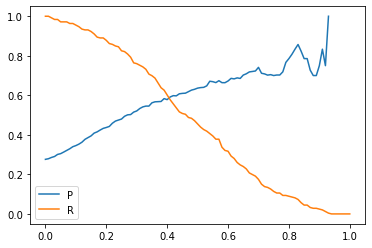

In [24]:
plt.plot(df_model.threshold, df_model['p'], label='P')
plt.plot(df_model.threshold, df_model['r'], label='R')
plt.legend()

In [26]:
df_model.threshold[40],df_model.p[40].round(1),df_model.r[40].round(1)

(0.4, 0.6, 0.6)

In [25]:
joint = list(((df_model.p-df_model.r).round(1))==0)

df_model.threshold[joint.index(True)]

0.39

# Q3.  thresold=0.4

# Question 4
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$
Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [27]:
df_model['F1'] = 2 * ((df_model.p * df_model.r )/ (df_model.p + df_model.r))

In [28]:
max_F1=df_model['F1'].max()
max_idx = list(df_model['F1'] == max_F1)
df_model.threshold[max_idx.index(True)]

0.32

# Q4.  threshold=0.3

# Question 5
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)
* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
* Use AUC to evaluate the model on validation

In [36]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [37]:
def predict(df, dv, model):
    dicts = df[features].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [33]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.default.values
    y_val = df_val.default.values

    dv, model = train(df_train, y_train, C=1)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.814 +- 0.015


# Q5.  std=0.015

# Question 6
Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: [0.01, 0.1, 1, 10]
* Initialize KFold with the same parameters as previously
* Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [34]:
from tqdm.auto import tqdm

In [35]:
n_splits = 5

for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values
        
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.809 +- 0.013
C=0.1 0.813 +- 0.014
C=1 0.814 +- 0.015
C=10 0.814 +- 0.015


# Q6. C=1